In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from prepare_dataset import MyDataset,subset_generator
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model,display_image
from vgg_pretrained import vgg_all_freezed,total_trainable_parameters,full_vgg,vgg_layer_freeze
from Model import Network,new_model
from Transform import Transform
from train_fn import train,validation,image_validation,validation_classes,train_w_transform
from tqdm import tqdm
from sklearn.metrics import classification_report


D:\anaconda\envs\affectnet2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullvgg=full_vgg()
total_trainable_parameters(fullvgg)
total_trainable_parameters(fullvgg.features)
total_trainable_parameters(vgg_all_freezed())
total_trainable_parameters(vgg_layer_freeze(24))


Total trainable parameters of VGG is 	 138357544

Total trainable parameters of Sequential is 	 14714688

Total trainable parameters of Sequential is 	 0

Total trainable parameters of Sequential is 	 7079424


In [3]:
# DATA LOADER PARAMETERS
batch=64
CUDA_LAUNCH_BLOCKING=1 

In [4]:
MyCuda_Stats()

No of GPUs i have is 1
0
My Graphic Card is NVIDIA GeForce RTX 2070 SUPER
Is Cuda Available True


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [6]:
anno_dir=r"./01_data/train_set/annotations"
image_dir=r"./01_data/train_set/images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [7]:
val_anno_dir=r"./01_data/val_set/annotations"
val_image_dir=r"./01_data/val_set/images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

In [8]:
Subset_train_sampler=subset_generator(train_data,5000)

In [9]:
train_loader=torch.utils.data.DataLoader(train_data,
                                         batch_size=batch,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         sampler=None)
val_loader=torch.utils.data.DataLoader(val_data,
                                       batch_size=batch,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [10]:
print(len(train_loader))
print(len(val_loader))


4495
63


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
feature_extractor=vgg_layer_freeze(17)
total_trainable_parameters(feature_extractor)



Total trainable parameters of Sequential is 	 12979200


In [13]:

#input_features_for_denselayer=get_output_features_of_model(model=feature_extractor,batch_size=32,dataloader=train_loader)
input_features_for_denselayer=25088


In [14]:
t_image=Transform(input_features_for_denselayer)
model1=new_model(feature_extractor,input_features_for_denselayer).to(device)
model1

new_model(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [15]:
total_trainable_parameters(model1)


Total trainable parameters of new_model is 	 115776520


In [16]:
lr=0.0001
#loss1=nn.CrossEntropyLoss()
#optimizer=optim.Adam(model1.parameters(),lr)

weights=[0.7,0.7,1,1,1,1,1,1]
loss1=nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
#loss_plain=nn.CrossEntropyLoss()
optimizer=optim.SGD(model1.parameters(),lr=0.0001,momentum=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


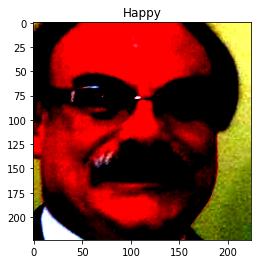

In [17]:
display_image(train_data[0][0],train_data[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


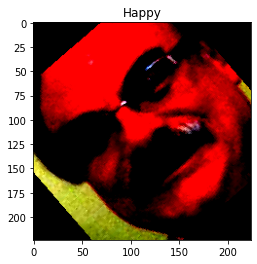

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


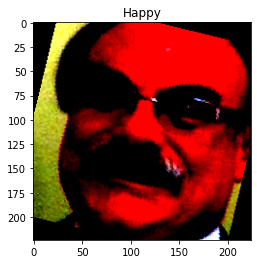

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


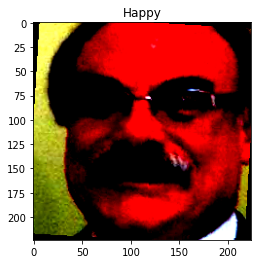

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


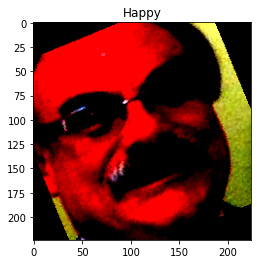

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


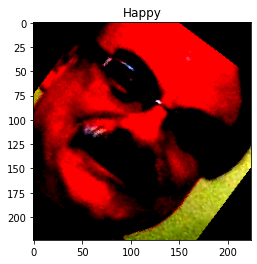

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


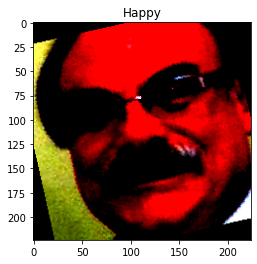

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


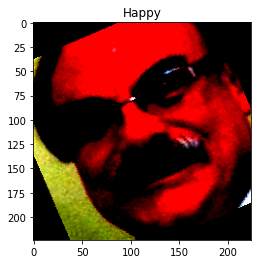

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


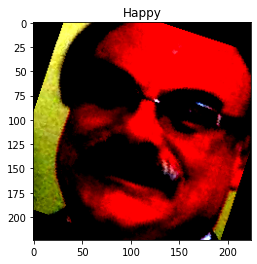

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


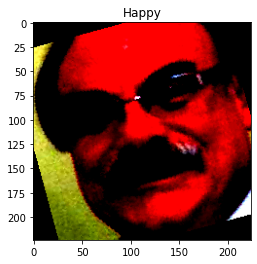

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


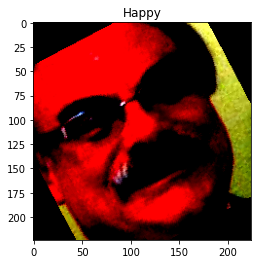

In [18]:
for _ in range(10):
    display_image(t_image.tran(train_data[0][0]),train_data[0][1])

In [19]:
model1.load_state_dict(torch.load(r"./01_data/modelrecent.pth"))

<All keys matched successfully>

In [20]:
#optimizer.load_state_dict(torch.load(r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizer1.pth"))

In [21]:
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [22]:
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']


In [23]:
print(len(train_data))

287651


In [ ]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

In [24]:
train_data.upsample()

Finding Class Counts...


100%|██████████| 287651/287651 [03:17<00:00, 1455.61it/s]


Balancing Class: Neutral


0it [00:00, ?it/s]


Balancing Class: Happy


0it [00:00, ?it/s]


Balancing Class: Sad


0it [00:00, ?it/s]


Balancing Class: Surprise


100%|██████████| 5910/5910 [00:01<00:00, 4214.46it/s]


Balancing Class: Fear


100%|██████████| 13622/13622 [00:03<00:00, 4243.98it/s]


Balancing Class: Disgust


100%|██████████| 16197/16197 [00:03<00:00, 4279.43it/s]


Balancing Class: Anger


0it [00:00, ?it/s]


Balancing Class: Contempt


100%|██████████| 16250/16250 [00:03<00:00, 4269.34it/s]


In [ ]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

In [25]:
len(train_data)

339630

In [25]:
validation(val_loader,model1,loss1)

100%|██████████| 63/63 [00:29<00:00,  2.11it/s]

test error-2.272154 
 Accuracy-48.012003%


In [26]:
validation_classes(val_loader_class,model1,loss1,0)

100%|██████████| 3999/3999 [00:16<00:00, 248.26it/s]

test error-0.701502 
 Accuracy-76.800000%


In [27]:
validation_classes(val_loader_class,model1,loss1,1)

100%|██████████| 3999/3999 [00:13<00:00, 292.79it/s]

test error-0.345160 
 Accuracy-89.200000%


In [28]:
validation_classes(val_loader_class,model1,loss1,2)

100%|██████████| 3999/3999 [00:13<00:00, 291.81it/s]

test error-1.427453 
 Accuracy-51.600000%


In [29]:
validation_classes(val_loader_class,model1,loss1,3)

100%|██████████| 3999/3999 [00:13<00:00, 293.36it/s]

test error-2.318290 
 Accuracy-41.600000%


In [30]:
validation_classes(val_loader_class,model1,loss1,4)

100%|██████████| 3999/3999 [00:13<00:00, 286.38it/s]

test error-2.487224 
 Accuracy-36.400000%


In [31]:
validation_classes(val_loader_class,model1,loss1,5)

100%|██████████| 3999/3999 [00:13<00:00, 286.15it/s]

test error-4.057422 
 Accuracy-26.000000%


In [32]:
validation_classes(val_loader_class,model1,loss1,6)

100%|██████████| 3999/3999 [00:13<00:00, 292.81it/s]

test error-1.685344 
 Accuracy-54.000000%


In [33]:
validation_classes(val_loader_class,model1,loss1,7)

100%|██████████| 3999/3999 [00:13<00:00, 291.73it/s]

test error-4.069240 
 Accuracy-8.416834%


In [34]:
# NO OF EPOCHS IS 5
epochs=20
for epoch in range(epochs):
    print(f'Epoch-{epoch}')
    train_w_transform(train_loader,model1,loss1,optimizer,t_image)
    validation(val_loader,model1,loss1)
    print(classes[0])
    validation_classes(val_loader_class,model1,loss1,0)
    print(classes[1])
    validation_classes(val_loader_class,model1,loss1,1)
    print(classes[2])
    validation_classes(val_loader_class,model1,loss1,2)
    print(classes[3])
    validation_classes(val_loader_class,model1,loss1,3)
    print(classes[4])
    validation_classes(val_loader_class,model1,loss1,4)
    print(classes[5])
    validation_classes(val_loader_class,model1,loss1,5)
    print(classes[6])
    validation_classes(val_loader_class,model1,loss1,6)
    print(classes[7])
    validation_classes(val_loader_class,model1,loss1,7)
    

Epoch-0


100%|██████████| 5307/5307 [23:26<00:00,  3.77it/s]


loss:0.000602 batch:5306/5307


100%|██████████| 63/63 [01:34<00:00,  1.49s/it] 


test error-8.682285 
 Accuracy-13.803451%
Neutral


100%|██████████| 3999/3999 [00:15<00:00, 252.62it/s]


test error-11.897369 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:14<00:00, 283.03it/s]


test error-12.520134 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 291.71it/s]


test error-8.501753 
 Accuracy-5.600000%
Surprise


100%|██████████| 3999/3999 [00:14<00:00, 284.23it/s]


test error-9.820514 
 Accuracy-0.800000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 291.19it/s]


test error-9.661881 
 Accuracy-2.200000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 296.98it/s]


test error-10.208111 
 Accuracy-1.600000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 291.99it/s]


test error-8.862953 
 Accuracy-0.400000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 291.39it/s]


test error-0.001201 
 Accuracy-100.000000%
Epoch-1


100%|██████████| 5307/5307 [23:38<00:00,  3.74it/s]


loss:0.109146 batch:5306/5307


100%|██████████| 63/63 [02:36<00:00,  2.48s/it]  


test error-5.542465 
 Accuracy-23.555889%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 293.89it/s]


test error-6.784273 
 Accuracy-2.200000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 298.51it/s]


test error-12.636747 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 300.16it/s]


test error-4.651677 
 Accuracy-26.200000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 302.26it/s]


test error-7.274542 
 Accuracy-8.000000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 301.27it/s]


test error-4.201879 
 Accuracy-20.600000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 301.84it/s]


test error-6.321140 
 Accuracy-21.000000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 301.56it/s]


test error-4.869598 
 Accuracy-12.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 300.85it/s]


test error-0.054291 
 Accuracy-98.597194%
Epoch-2


100%|██████████| 5307/5307 [23:02<00:00,  3.84it/s]


loss:0.002640 batch:5306/5307


100%|██████████| 63/63 [00:23<00:00,  2.72it/s]


test error-6.929539 
 Accuracy-23.805951%
Neutral


100%|██████████| 3999/3999 [00:12<00:00, 309.84it/s]


test error-9.784629 
 Accuracy-0.400000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.07it/s]


test error-9.602714 
 Accuracy-0.400000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.64it/s]


test error-9.026986 
 Accuracy-19.000000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 302.59it/s]


test error-7.393833 
 Accuracy-18.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.14it/s]


test error-5.901095 
 Accuracy-26.800000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 302.09it/s]


test error-9.816195 
 Accuracy-5.000000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 293.22it/s]


test error-5.471244 
 Accuracy-21.600000%
Contempt


100%|██████████| 3999/3999 [00:12<00:00, 310.03it/s]


test error-0.032259 
 Accuracy-99.198397%
Epoch-3


100%|██████████| 5307/5307 [22:58<00:00,  3.85it/s]


loss:0.000160 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


test error-9.364992 
 Accuracy-16.254064%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.48it/s]


test error-11.998555 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.67it/s]


test error-13.556497 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.39it/s]


test error-10.984391 
 Accuracy-1.000000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 292.56it/s]


test error-12.078458 
 Accuracy-5.800000%
Fear


100%|██████████| 3999/3999 [00:12<00:00, 307.73it/s]


test error-7.547555 
 Accuracy-11.600000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 301.37it/s]


test error-9.901358 
 Accuracy-11.800000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 306.59it/s]


test error-10.769184 
 Accuracy-0.800000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 304.74it/s]


test error-0.050412 
 Accuracy-99.198397%
Epoch-4


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.000455 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


test error-9.404110 
 Accuracy-14.178545%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 304.78it/s]


test error-10.931907 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 304.72it/s]


test error-11.275263 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 304.99it/s]


test error-10.821844 
 Accuracy-1.400000%
Surprise


100%|██████████| 3999/3999 [00:12<00:00, 308.13it/s]


test error-11.350214 
 Accuracy-3.800000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 305.45it/s]


test error-9.255978 
 Accuracy-2.400000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 300.67it/s]


test error-10.543323 
 Accuracy-6.400000%
Anger


100%|██████████| 3999/3999 [00:12<00:00, 308.51it/s]


test error-11.938501 
 Accuracy-0.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.61it/s]


test error-0.029390 
 Accuracy-99.599198%
Epoch-5


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.000540 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-8.788688 
 Accuracy-13.528382%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.27it/s]


test error-10.433483 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.05it/s]


test error-9.399793 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.88it/s]


test error-10.082181 
 Accuracy-1.200000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 305.27it/s]


test error-10.229512 
 Accuracy-1.600000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 307.13it/s]


test error-9.239129 
 Accuracy-0.600000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 306.25it/s]


test error-10.143814 
 Accuracy-6.400000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 306.98it/s]


test error-11.371474 
 Accuracy-0.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.00it/s]


test error-0.030959 
 Accuracy-98.597194%
Epoch-6


100%|██████████| 5307/5307 [22:56<00:00,  3.85it/s]


loss:0.000459 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-7.553829 
 Accuracy-15.778945%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 304.37it/s]


test error-9.124381 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.57it/s]


test error-8.560994 
 Accuracy-0.200000%
Sad


100%|██████████| 3999/3999 [00:14<00:00, 283.67it/s]


test error-6.562262 
 Accuracy-11.400000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 297.07it/s]


test error-10.247282 
 Accuracy-4.400000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.28it/s]


test error-8.379208 
 Accuracy-2.000000%
Disgust


100%|██████████| 3999/3999 [00:12<00:00, 307.88it/s]


test error-9.672139 
 Accuracy-9.000000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 304.62it/s]


test error-8.581204 
 Accuracy-0.200000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.64it/s]


test error-0.031816 
 Accuracy-99.198397%
Epoch-7


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.104185 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.86it/s]


test error-4.762118 
 Accuracy-28.707177%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.44it/s]


test error-7.657067 
 Accuracy-0.800000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.17it/s]


test error-8.923737 
 Accuracy-1.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 291.71it/s]


test error-4.832370 
 Accuracy-29.800000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 293.50it/s]


test error-4.541950 
 Accuracy-23.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.58it/s]


test error-3.715718 
 Accuracy-31.600000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 306.70it/s]


test error-5.409160 
 Accuracy-29.800000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 306.61it/s]


test error-5.029543 
 Accuracy-15.600000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.48it/s]


test error-0.064855 
 Accuracy-97.995992%
Epoch-8


100%|██████████| 5307/5307 [22:56<00:00,  3.85it/s]


loss:0.000371 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-5.206336 
 Accuracy-24.631158%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 300.38it/s]


test error-7.407337 
 Accuracy-0.600000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.50it/s]


test error-7.750675 
 Accuracy-1.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.24it/s]


test error-5.852318 
 Accuracy-20.000000%
Surprise


100%|██████████| 3999/3999 [00:12<00:00, 308.48it/s]


test error-4.786509 
 Accuracy-21.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.20it/s]


test error-3.553634 
 Accuracy-32.800000%
Disgust


100%|██████████| 3999/3999 [00:12<00:00, 307.97it/s]


test error-7.048909 
 Accuracy-18.800000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 305.07it/s]


test error-6.601337 
 Accuracy-3.600000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.95it/s]


test error-0.056419 
 Accuracy-99.198397%
Epoch-9


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.008683 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-5.583630 
 Accuracy-24.656164%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.02it/s]


test error-9.534624 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 293.16it/s]


test error-6.929139 
 Accuracy-1.200000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.00it/s]


test error-8.243914 
 Accuracy-11.400000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 302.06it/s]


test error-5.618402 
 Accuracy-11.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.38it/s]


test error-4.162595 
 Accuracy-30.200000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 307.44it/s]


test error-5.088398 
 Accuracy-37.000000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 305.62it/s]


test error-6.568766 
 Accuracy-7.200000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.02it/s]


test error-0.046883 
 Accuracy-99.198397%
Epoch-10


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.010378 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.86it/s]


test error-6.812384 
 Accuracy-22.380595%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.35it/s]


test error-9.787805 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.87it/s]


test error-7.298682 
 Accuracy-1.200000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.81it/s]


test error-11.939863 
 Accuracy-5.600000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 298.03it/s]


test error-6.574797 
 Accuracy-9.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.16it/s]


test error-5.820674 
 Accuracy-26.400000%
Disgust


100%|██████████| 3999/3999 [00:12<00:00, 307.78it/s]


test error-5.799106 
 Accuracy-34.600000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 305.85it/s]


test error-8.246195 
 Accuracy-3.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.22it/s]


test error-0.026299 
 Accuracy-99.198397%
Epoch-11


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.021618 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-4.136976 
 Accuracy-24.431108%
Neutral


100%|██████████| 3999/3999 [00:12<00:00, 309.23it/s]


test error-6.850253 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.82it/s]


test error-6.798077 
 Accuracy-0.600000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 304.65it/s]


test error-4.771113 
 Accuracy-17.600000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 302.00it/s]


test error-4.623119 
 Accuracy-3.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 302.03it/s]


test error-3.236477 
 Accuracy-26.000000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 307.15it/s]


test error-3.419895 
 Accuracy-41.200000%
Anger


100%|██████████| 3999/3999 [00:12<00:00, 310.28it/s]


test error-4.885836 
 Accuracy-8.600000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.27it/s]


test error-0.098181 
 Accuracy-98.396794%
Epoch-12


100%|██████████| 5307/5307 [22:58<00:00,  3.85it/s]


loss:0.005976 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


test error-4.713293 
 Accuracy-20.955239%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.90it/s]


test error-7.391667 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 304.88it/s]


test error-6.266673 
 Accuracy-0.400000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 306.90it/s]


test error-5.749934 
 Accuracy-9.200000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 305.86it/s]


test error-5.472284 
 Accuracy-1.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.37it/s]


test error-4.567107 
 Accuracy-10.800000%
Disgust


100%|██████████| 3999/3999 [00:14<00:00, 285.43it/s]


test error-3.762391 
 Accuracy-44.000000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 306.53it/s]


test error-5.692331 
 Accuracy-3.400000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.01it/s]


test error-0.070366 
 Accuracy-98.797595%
Epoch-13


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.034123 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


test error-7.668131 
 Accuracy-15.428857%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 306.64it/s]


test error-10.202705 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.52it/s]


test error-7.750222 
 Accuracy-0.200000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.28it/s]


test error-9.479820 
 Accuracy-0.600000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 307.50it/s]


test error-11.313673 
 Accuracy-0.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 305.56it/s]


test error-9.359156 
 Accuracy-1.800000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 307.37it/s]


test error-5.430133 
 Accuracy-20.800000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 305.94it/s]


test error-8.604073 
 Accuracy-0.200000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.57it/s]


test error-0.006057 
 Accuracy-99.799599%
Epoch-14


100%|██████████| 5307/5307 [22:58<00:00,  3.85it/s]


loss:0.000827 batch:5306/5307


100%|██████████| 63/63 [00:22<00:00,  2.86it/s]


test error-7.358706 
 Accuracy-15.678920%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.92it/s]


test error-9.599364 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.09it/s]


test error-8.020857 
 Accuracy-0.600000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.93it/s]


test error-8.854474 
 Accuracy-1.000000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 306.53it/s]


test error-10.557981 
 Accuracy-0.400000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 305.42it/s]


test error-9.051695 
 Accuracy-2.000000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 307.43it/s]


test error-5.328556 
 Accuracy-21.600000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 306.17it/s]


test error-8.313912 
 Accuracy-0.800000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 295.41it/s]


test error-0.020661 
 Accuracy-99.198397%
Epoch-15


100%|██████████| 5307/5307 [22:56<00:00,  3.86it/s]


loss:0.003193 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


test error-5.218454 
 Accuracy-19.204801%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.38it/s]


test error-7.585767 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.62it/s]


test error-6.091903 
 Accuracy-1.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.16it/s]


test error-6.679940 
 Accuracy-4.400000%
Surprise


100%|██████████| 3999/3999 [00:12<00:00, 307.71it/s]


test error-6.606924 
 Accuracy-0.400000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 305.25it/s]


test error-5.262319 
 Accuracy-6.400000%
Disgust


100%|██████████| 3999/3999 [00:12<00:00, 308.16it/s]


test error-3.621641 
 Accuracy-39.200000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 305.07it/s]


test error-6.820884 
 Accuracy-4.200000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.72it/s]


test error-0.049981 
 Accuracy-98.196393%
Epoch-16


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.006418 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-4.492739 
 Accuracy-25.056264%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 305.52it/s]


test error-7.188607 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.62it/s]


test error-6.045596 
 Accuracy-1.200000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.44it/s]


test error-5.468423 
 Accuracy-16.400000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 306.66it/s]


test error-5.372436 
 Accuracy-2.800000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.30it/s]


test error-3.162063 
 Accuracy-29.600000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 306.41it/s]


test error-3.574221 
 Accuracy-44.200000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 306.47it/s]


test error-6.310166 
 Accuracy-8.600000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 305.39it/s]


test error-0.072947 
 Accuracy-97.795591%
Epoch-17


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.016278 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.86it/s]


test error-3.967470 
 Accuracy-23.105776%
Neutral


100%|██████████| 3999/3999 [00:12<00:00, 308.96it/s]


test error-6.275816 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 305.48it/s]


test error-7.130357 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 300.89it/s]


test error-4.638510 
 Accuracy-10.000000%
Surprise


100%|██████████| 3999/3999 [00:12<00:00, 308.30it/s]


test error-4.340495 
 Accuracy-1.800000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 305.16it/s]


test error-2.871458 
 Accuracy-28.000000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 307.34it/s]


test error-2.799645 
 Accuracy-42.600000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 304.98it/s]


test error-5.249522 
 Accuracy-4.400000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.26it/s]


test error-0.063977 
 Accuracy-98.196393%
Epoch-18


100%|██████████| 5307/5307 [22:58<00:00,  3.85it/s]


loss:0.003635 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


test error-5.356572 
 Accuracy-18.754689%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 306.57it/s]


test error-8.850248 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.69it/s]


test error-10.323160 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 296.82it/s]


test error-5.863464 
 Accuracy-7.600000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 297.12it/s]


test error-5.882617 
 Accuracy-0.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 291.79it/s]


test error-3.620588 
 Accuracy-15.400000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 294.34it/s]


test error-3.801322 
 Accuracy-27.200000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 300.08it/s]


test error-7.019072 
 Accuracy-1.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.64it/s]


test error-0.031765 
 Accuracy-98.797595%
Epoch-19


100%|██████████| 5307/5307 [22:57<00:00,  3.85it/s]


loss:0.003105 batch:5306/5307


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


test error-5.752959 
 Accuracy-17.554389%
Neutral


100%|██████████| 3999/3999 [00:13<00:00, 304.32it/s]


test error-9.280252 
 Accuracy-0.000000%
Happy


100%|██████████| 3999/3999 [00:13<00:00, 306.25it/s]


test error-10.179028 
 Accuracy-0.000000%
Sad


100%|██████████| 3999/3999 [00:13<00:00, 305.01it/s]


test error-6.246295 
 Accuracy-6.800000%
Surprise


100%|██████████| 3999/3999 [00:13<00:00, 307.05it/s]


test error-6.463857 
 Accuracy-0.200000%
Fear


100%|██████████| 3999/3999 [00:13<00:00, 306.86it/s]


test error-3.764283 
 Accuracy-14.800000%
Disgust


100%|██████████| 3999/3999 [00:13<00:00, 306.38it/s]


test error-4.709820 
 Accuracy-19.200000%
Anger


100%|██████████| 3999/3999 [00:13<00:00, 288.35it/s]


test error-7.747343 
 Accuracy-0.000000%
Contempt


100%|██████████| 3999/3999 [00:13<00:00, 306.93it/s]

test error-0.013844 
 Accuracy-99.599198%


In [ ]:
torch.save(model1.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\modelrecent.pth")

In [ ]:
torch.save(optimizer.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizerrecent.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device='cuda', abbreviated=True)